# 周期测试脚本

## 1. 季度收益

In [ ]:
import yfinance as yf
import akshare as ak
import pandas as pd


# 配置参数
START_DATE = "2025-07-01"
END_DATE = "2025-10-01"

CHINA_ETFS = {
    "513010": "恒生科技",
    "159892": "恒生医药",
    "159934": "黄金ETF",
    "159985": "豆粕ETF",
    "510880": "红利ETF",
    "159941": "纳斯达克ETF",
    "516780": "稀土ETF",
    "513650": "标普500ETF",
}

ASSET_NAME_MAP = {
    "513010": "恒生科技ETF",
    "159892": "恒生医药ETF",
    "159934": "黄金ETF",
    "159985": "豆粕ETF",
    "510880": "红利ETF",
    "516780": "稀土ETF",
    "159941": "纳斯达克ETF",
    "513650": "标普500ETF",
}

def _download_one_code(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.DataFrame:
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    data = ak.fund_etf_hist_em(symbol=str(code), period="daily", start_date=sd, end_date=ed, adjust=adjust)
    if data is None or data.empty:
        raise RuntimeError(f"{code} 无数据")
    d = data.rename(columns={"日期": "date", "收盘": "close"})
    d["date"] = pd.to_datetime(d["date"])
    d = d.set_index("date")[["close"]].sort_index()
    return d

def calculate_return(start_price, end_price):
    return float((end_price / start_price - 1) * 100)

returns = {}

# 国内 ETF
for code in CHINA_ETFS.keys():
    try:
        df = _download_one_code(code, START_DATE, END_DATE)
        returns[code] = calculate_return(float(df["close"].iloc[0]), float(df["close"].iloc[-1]))
    except Exception as e:
        print(f"{code} 数据获取失败:", e)

# 转换 DataFrame
returns_df = pd.DataFrame(
    [{"代码": k, "名称": ASSET_NAME_MAP[k], "收益率(%)": float(v)} for k, v in returns.items() if v is not None]
)

returns_df = returns_df.sort_values(by="收益率(%)", ascending=False).reset_index(drop=True)

print("\n===== 资产收益率结果 =====\n")
print(returns_df.to_string(index=False))


## 2. 本周涨跌

In [1]:
# -*- coding: utf-8 -*-
import akshare as ak
import pandas as pd
from datetime import datetime, timedelta

# ========= 参数配置 =========
END_DATE = "2025-11-06"   # 按周四截止日（含）
TRADING_DAYS = 5          # “一周”的交易日个数
BUFFER_DAYS = 60          # 向前预取的自然日范围，确保能攒够 N 天
ADJUST = "qfq"            # 复权方式：qfq/None。akshare 用 "" 表示不复权
BASELINE = "open"         # 收益率基准：'open'（首日开盘）或 'close'（首日收盘）

ETFS = {
    "159934": "黄金ETF",
    "513630": "红利ETF",
    "159941": "纳斯达克ETF",
    "516780": "稀土ETF",
    "513650": "标普500ETF",
    "513310": "半导体etf",
    "513880": "日经etf",
}

# ========= 数据获取 =========
def fetch_etf_df(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.DataFrame:
    """
    从 akshare 拉取日线数据，返回按日期升序且仅含 open/close 的 DataFrame，index 为 date。
    """
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    df = ak.fund_etf_hist_em(symbol=str(code), period="daily", start_date=sd, end_date=ed, adjust=adjust)
    if df is None or df.empty:
        raise RuntimeError("无数据")

    # 只保留需要的列并规范化
    rename_map = {"日期": "date", "开盘": "open", "收盘": "close"}
    missing = [col for col in rename_map if col not in df.columns]
    if missing:
        raise RuntimeError(f"缺少字段: {missing}")

    df = df.rename(columns=rename_map)
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")[["open", "close"]].sort_index()

    # 清洗非数值
    for c in ["open", "close"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["open", "close"])
    return df

# ========= 指标计算 =========
def trading_week_metrics(code: str, end_date: str, n_days: int = 5, baseline: str = "open"):
    """
    以 end_date 为截止，从历史里取最近 n_days 个【该标的有数据的交易日】计算收益。
    baseline: 'open' 表示用首日开盘作基准；'close' 表示用首日收盘作基准。
    返回：收益率、样本交易日数、样本起止日期、基准口径及价格、截止日收盘价、缓冲内总交易日数、备注，及原始DF。
    """
    if baseline not in ("open", "close"):
        raise ValueError("baseline 仅支持 'open' 或 'close'")

    end_dt = datetime.strptime(end_date, "%Y-%m-%d").date()
    start_dt = end_dt - timedelta(days=BUFFER_DAYS)

    raw_df = fetch_etf_df(code, start_dt.isoformat(), end_dt.isoformat(), adjust=ADJUST)
    # 只保留截止日及之前
    raw_df = raw_df[raw_df.index.date <= end_dt]

    total_days_in_buffer = len(raw_df)
    if total_days_in_buffer == 0:
        return {
            "收益率(%)": None, "样本交易日数": 0, "样本起日": None, "样本止日": None,
            "基准(首日)": baseline, "首日基准价": None, "截止日收盘价": None,
            "总交易日数(缓冲)": 0, "备注": "截止日前无交易数据", "raw_df": raw_df
        }

    tail = raw_df.tail(n_days)
    used_days = len(tail)
    start_used = tail.index[0].date().isoformat()
    end_used = tail.index[-1].date().isoformat()

    if used_days < 2:
        return {
            "收益率(%)": None, "样本交易日数": used_days, "样本起日": start_used, "样本止日": end_used,
            "基准(首日)": baseline, "首日基准价": float(tail[baseline].iloc[0]) if used_days >= 1 else None,
            "截止日收盘价": float(tail["close"].iloc[-1]) if used_days >= 1 else None,
            "总交易日数(缓冲)": total_days_in_buffer, "备注": f"可用交易日不足（仅 {used_days} 天）", "raw_df": raw_df
        }

    base_price = float(tail[baseline].iloc[0])
    last_close = float(tail["close"].iloc[-1])

    if base_price == 0:
        return {
            "收益率(%)": None, "样本交易日数": used_days, "样本起日": start_used, "样本止日": end_used,
            "基准(首日)": baseline, "首日基准价": base_price, "截止日收盘价": last_close,
            "总交易日数(缓冲)": total_days_in_buffer, "备注": "首日基准价为 0（无效）", "raw_df": raw_df
        }

    ret = (last_close / base_price - 1.0) * 100.0
    remark = None if last_close != base_price else "首末价相同"

    return {
        "收益率(%)": round(float(ret), 6),
        "样本交易日数": used_days,
        "样本起日": start_used,
        "样本止日": end_used,
        "基准(首日)": baseline,
        "首日基准价": base_price,
        "截止日收盘价": last_close,
        "总交易日数(缓冲)": total_days_in_buffer,
        "备注": remark,
        "raw_df": raw_df
    }

# ========= 计算与展示 =========
def main():
    rows = []
    raw_store = {}  # 保存原始数据，供末尾打印最近 N 天

    for code, name in ETFS.items():
        try:
            m = trading_week_metrics(code, END_DATE, TRADING_DAYS, BASELINE)
            rows.append({
                "代码": code,
                "名称": name,
                "收益率(%)": m["收益率(%)"],
                "样本交易日数": m["样本交易日数"],
                "样本起日": m["样本起日"],
                "样本止日": m["样本止日"],
                "基准(首日)": "开盘" if m["基准(首日)"] == "open" else "收盘",
                "首日基准价": m["首日基准价"],
                "截止日收盘价": m["截止日收盘价"],
                "备注": m["备注"],
            })
            raw_store[code] = m["raw_df"]
        except Exception as e:
            rows.append({
                "代码": code, "名称": name,
                "收益率(%)": None, "样本交易日数": 0,
                "样本起日": None, "样本止日": None,
                "基准(首日)": "开盘" if BASELINE == "open" else "收盘",
                "首日基准价": None, "截止日收盘价": None,
                "备注": str(e),
            })
            raw_store[code] = pd.DataFrame(columns=["open", "close"])

    result = pd.DataFrame(rows)

    # 成功项（收益率非空）优先展示；列顺序：收益率 -> 交易日数
    ok = result[result["收益率(%)"].notna()].sort_values("收益率(%)", ascending=False)
    bad = result[result["收益率(%)"].isna()]

    print("\n===== 按交易日的一周收益率（截至 {}，近 {} 个交易日；基准：{}）=====\n"
          .format(END_DATE, TRADING_DAYS, "首日开盘→截止日收盘" if BASELINE=="open" else "首日收盘→截止日收盘"))

    if not ok.empty:
        print(ok[["代码", "名称", "收益率(%)", "样本交易日数", "样本起日", "样本止日",
                  "基准(首日)", "首日基准价", "截止日收盘价"]].to_string(index=False))

    if not bad.empty:
        print("\n===== 未计算成功 / 无效样本（原因）=====\n")
        print(bad[["代码", "名称", "收益率(%)", "样本交易日数", "样本起日", "样本止日", "备注"]].to_string(index=False))

    # —— 原始数据逐个代码输出：只显示设定的交易日数 ——
    print("\n===== 各标的原始数据（最近 {} 个交易日，截止 {}）=====\n".format(TRADING_DAYS, END_DATE))
    for code, name in ETFS.items():
        df = raw_store.get(code, pd.DataFrame(columns=["open", "close"]))
        disp = df.tail(TRADING_DAYS).reset_index().rename(columns={"date": "日期", "open": "开盘", "close": "收盘"})
        print(f"--- {code} {name} ---")
        if disp.empty:
            print("无数据\n")
            continue
        disp["日期"] = disp["日期"].dt.strftime("%Y-%m-%d")
        # 只保留三列，按你需求
        print(disp[["日期", "开盘", "收盘"]].to_string(index=False))
        print()

if __name__ == "__main__":
    main()


  0%|          | 0/12 [00:00<?, ?it/s]


===== 按交易日的一周收益率（截至 2025-11-06，近 5 个交易日；基准：首日开盘→截止日收盘）=====

    代码       名称    收益率(%)  样本交易日数       样本起日       样本止日 基准(首日)  首日基准价  截止日收盘价
513630    红利ETF  2.219482       5 2025-10-31 2025-11-06     开盘  1.622   1.658
159934    黄金ETF -0.770483       5 2025-10-31 2025-11-06     开盘  9.215   9.144
159941  纳斯达克ETF -0.955631       5 2025-10-31 2025-11-06     开盘  1.465   1.451
513650 标普500ETF -1.160862       5 2025-10-31 2025-11-06     开盘  1.809   1.788
513880    日经etf -2.942722       5 2025-10-31 2025-11-06     开盘  1.903   1.847
513310   半导体etf -3.203744       5 2025-10-31 2025-11-06     开盘  2.778   2.689
516780    稀土ETF -3.563596       5 2025-10-31 2025-11-06     开盘  1.824   1.759

===== 各标的原始数据（最近 5 个交易日，截止 2025-11-06）=====

--- 159934 黄金ETF ---
        日期    开盘    收盘
2025-10-31 9.215 9.177
2025-11-03 9.140 9.187
2025-11-04 9.136 9.124
2025-11-05 9.048 9.093
2025-11-06 9.103 9.144

--- 513630 红利ETF ---
        日期    开盘    收盘
2025-10-31 1.622 1.611
2025-11-03 1.611 1.627
2025-11-04 1.629 1

标普500   300   300/4 = 75  019305    
纳斯达克   732   732/4 = 183  006479   
黄金    1033   004253   
债券    634   001061   
红利    273   513630  021514   
日经    120   513880  020713  
半导体    80    513310  019455
稀土    160   --159713--  516780  014332

## 3. 标普黄金比

In [21]:
# -*- coding: utf-8 -*-
import akshare as ak
import pandas as pd
from datetime import datetime, timedelta

# ========= 参数 =========
START_DATE = "2025-06-01"  # 起始日（含），格式 YYYY-MM-DD
END_DATE   = "2025-09-26"  # 截止日（含）
ADJUST     = "qfq"         # 复权方式：'qfq' 前复权；'' 不复权
SHOW_LAST_N = 20           # 结果仅展示最近 N 个共同交易日；设为 None 显示全部
SAVE_CSV_PATH = ""         # 例如 "nas_sp_gold_ratio.csv"，为空则不保存

# 代码映射（使用你上面给的）
CODES = {
    "NASDAQ": {"code": "159941", "name": "纳斯达克ETF"},
    "SP500":  {"code": "513650", "name": "标普500ETF"},
    "GOLD":   {"code": "159934", "name": "黄金ETF"},
}

def fetch_close_series(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.Series:
    """从 akshare 拉该 ETF 的日线收盘序列，返回 pd.Series(index=datetime, name=code)。"""
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    df = ak.fund_etf_hist_em(symbol=str(code), period="daily", start_date=sd, end_date=ed, adjust=adjust)
    if df is None or df.empty:
        raise RuntimeError(f"{code} 无数据")
    # 规范列
    df = df.rename(columns={"日期": "date", "收盘": "close"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    s = pd.to_numeric(df["close"], errors="coerce")
    s.index = df["date"].values
    s.name = code
    s = s.dropna()
    # 仅保留 <= END_DATE 的记录（akshare已按区间返回，这里稳妥再筛一次）
    end_dt = datetime.strptime(END_DATE, "%Y-%m-%d")
    s = s[s.index <= end_dt]
    return s

def main():
    # 拉三只标的的收盘价
    s_nas = fetch_close_series(CODES["NASDAQ"]["code"], START_DATE, END_DATE, ADJUST)
    s_sp  = fetch_close_series(CODES["SP500"]["code"],  START_DATE, END_DATE, ADJUST)
    s_au  = fetch_close_series(CODES["GOLD"]["code"],   START_DATE, END_DATE, ADJUST)

    # 以共同交易日对齐（内连接）
    df = pd.concat([s_nas, s_sp, s_au], axis=1, join="inner")
    df.columns = [CODES["NASDAQ"]["code"], CODES["SP500"]["code"], CODES["GOLD"]["code"]]

    if df.empty:
        raise RuntimeError("共同交易日为空，请调整日期区间或检查代码。")

    # 计算比值：指数ETF / 黄金ETF
    df["纳斯达克/黄金"] = df[CODES["NASDAQ"]["code"]] / df[CODES["GOLD"]["code"]]
    df["标普500/黄金"] = df[CODES["SP500"]["code"]]   / df[CODES["GOLD"]["code"]]

    # 整理展示列
    out = df[[CODES["NASDAQ"]["code"], CODES["SP500"]["code"], CODES["GOLD"]["code"], "纳斯达克/黄金", "标普500/黄金"]].copy()

    # 只显示最近 N 个共同交易日
    if isinstance(SHOW_LAST_N, int) and SHOW_LAST_N > 0:
        view = out.tail(SHOW_LAST_N)
    else:
        view = out

    # 打印结果
    print("\n===== 纳斯达克/黄金、标普/黄金（共同交易日对齐）=====")
    print(f"区间：{START_DATE} ~ {END_DATE} | 复权：{ADJUST or '不复权'} | 共同交易日数：{len(out)}\n")
    # 美化索引为日期字符串
    view_disp = view.copy()
    view_disp.index = view_disp.index.strftime("%Y-%m-%d")
    # 给原始价格列加上名称提示
    view_disp = view_disp.rename(columns={
        CODES["NASDAQ"]["code"]: f"{CODES['NASDAQ']['name']}({CODES['NASDAQ']['code']})",
        CODES["SP500"]["code"]:  f"{CODES['SP500']['name']}({CODES['SP500']['code']})",
        CODES["GOLD"]["code"]:   f"{CODES['GOLD']['name']}({CODES['GOLD']['code']})",
    })
    print(view_disp.to_string())

    # 打印最后一个交易日的两条比值
    last_dt = out.index[-1].strftime("%Y-%m-%d")
    print("\n—— 截止 {} 的比值 ——".format(last_dt))
    print("纳斯达克/黄金：{:.6f}".format(out.iloc[-1]["纳斯达克/黄金"]))
    print("标普500/黄金：{:.6f}".format(out.iloc[-1]["标普500/黄金"]))

    # 可选：保存 CSV
    if SAVE_CSV_PATH:
        out_to_save = out.copy()
        out_to_save.index = out_to_save.index.strftime("%Y-%m-%d")
        out_to_save.to_csv(SAVE_CSV_PATH, encoding="utf-8-sig")
        print(f"\n已保存到：{SAVE_CSV_PATH}")

if __name__ == "__main__":
    main()



===== 纳斯达克/黄金、标普/黄金（共同交易日对齐）=====
区间：2025-06-01 ~ 2025-09-26 | 复权：qfq | 共同交易日数：84

            纳斯达克ETF(159941)  标普500ETF(513650)  黄金ETF(159934)   纳斯达克/黄金  标普500/黄金
2025-09-01            1.257             1.655          7.976  0.157598  0.207497
2025-09-02            1.258             1.657          8.008  0.157093  0.206918
2025-09-03            1.256             1.651          8.108  0.154909  0.203626
2025-09-04            1.263             1.657          8.092  0.156080  0.204770
2025-09-05            1.278             1.671          8.119  0.157409  0.205814
2025-09-08            1.272             1.664          8.196  0.155198  0.203026
2025-09-09            1.277             1.668          8.322  0.153449  0.200433
2025-09-10            1.283             1.674          8.304  0.154504  0.201590
2025-09-11            1.282             1.676          8.276  0.154906  0.202513
2025-09-12            1.286             1.687          8.305  0.154846  0.203131
2025-09-15            1.2


===== 结果区间：2021-01-01 ~ 2025-09-30 =====
共同交易日数量：665
最后一个交易日： 2025-09-30
纳斯达克/黄金：0.153379
HSKJ_ETF / 黄金：0.175945


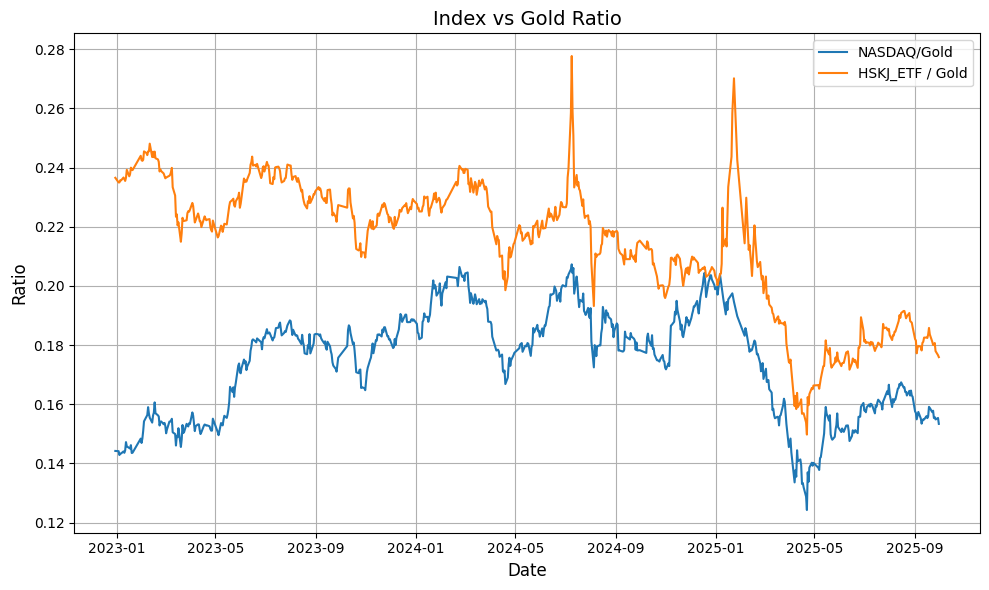

In [5]:
# -*- coding: utf-8 -*-
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt

# ===== 参数 =====
START_DATE = "2021-01-01"
END_DATE   = "2025-09-30"
ADJUST     = "qfq"

# 核心 ETF 代码
CODES = {
    "NASDAQ": {"code": "159941", "name": "纳斯达克ETF"},
    # "SP500":  {"code": "513650", "name": "标普500ETF"},
    "GOLD":   {"code": "159934", "name": "黄金ETF"},
}

# 自定义额外股票（比如沪深300 ETF）
CUSTOM = {"code": "159687", "name": "HSKJ_ETF"}

# ===== 工具函数 =====
def fetch_close_series(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.Series:
    """从 akshare 获取收盘价序列"""
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    df = ak.fund_etf_hist_em(symbol=str(code), period="daily", start_date=sd, end_date=ed, adjust=adjust)
    if df is None or df.empty:
        raise RuntimeError(f"{code} 无数据")
    df = df.rename(columns={"日期": "date", "收盘": "close"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    s = pd.to_numeric(df["close"], errors="coerce")
    s.index = df["date"].values
    s.name = code
    return s.dropna()

# ===== 主程序 =====
def main():
    # 拉取数据
    s_nas = fetch_close_series(CODES["NASDAQ"]["code"], START_DATE, END_DATE, ADJUST)
    # s_sp  = fetch_close_series(CODES["SP500"]["code"],  START_DATE, END_DATE, ADJUST)
    s_au  = fetch_close_series(CODES["GOLD"]["code"],   START_DATE, END_DATE, ADJUST)
    s_cus = fetch_close_series(CUSTOM["code"], START_DATE, END_DATE, ADJUST)

    # 合并共同交易日
    # df = pd.concat([s_nas, s_sp, s_au, s_cus], axis=1, join="inner")
    # df.columns = ["NASDAQ", "SP500", "GOLD", "CUSTOM"]
    df = pd.concat([s_nas, s_au, s_cus], axis=1, join="inner")
    df.columns = ["NASDAQ", "GOLD", "CUSTOM"]

    # 计算比率
    df["NASDAQ/Gold"] = df["NASDAQ"] / df["GOLD"]
    # df["SP500/Gold"]  = df["SP500"]  / df["GOLD"]
    df["Custom/Gold"] = df["CUSTOM"] / df["GOLD"]

    # 中文提示
    print(f"\n===== 结果区间：{START_DATE} ~ {END_DATE} =====")
    print(f"共同交易日数量：{len(df)}")
    print("最后一个交易日：", df.index[-1].strftime("%Y-%m-%d"))
    print("纳斯达克/黄金：{:.6f}".format(df.iloc[-1]["NASDAQ/Gold"]))
    # print("标普500/黄金：{:.6f}".format(df.iloc[-1]["SP500/Gold"]))
    print("{} / 黄金：{:.6f}".format(CUSTOM["name"], df.iloc[-1]["Custom/Gold"]))

    # ===== 画图（英文） =====
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df["NASDAQ/Gold"], label="NASDAQ/Gold")
    # plt.plot(df.index, df["SP500/Gold"],  label="SP500/Gold")
    plt.plot(df.index, df["Custom/Gold"], label=f"{CUSTOM['name']} / Gold")
    plt.title("Index vs Gold Ratio", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ratio", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


#### 归一化版本


===== 结果区间：2021-01-01 ~ 2025-09-30 =====
共同交易日数量：665
最后一个交易日： 2025-09-30
纳斯达克/黄金：0.153379
标普500/黄金：0.543070
xitu_ETF / 黄金：0.175945


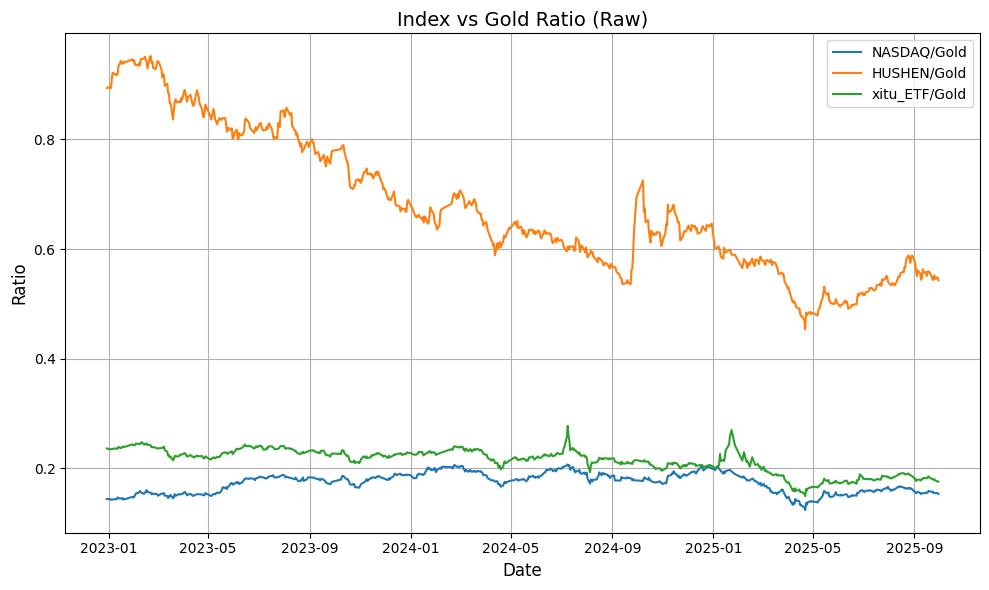

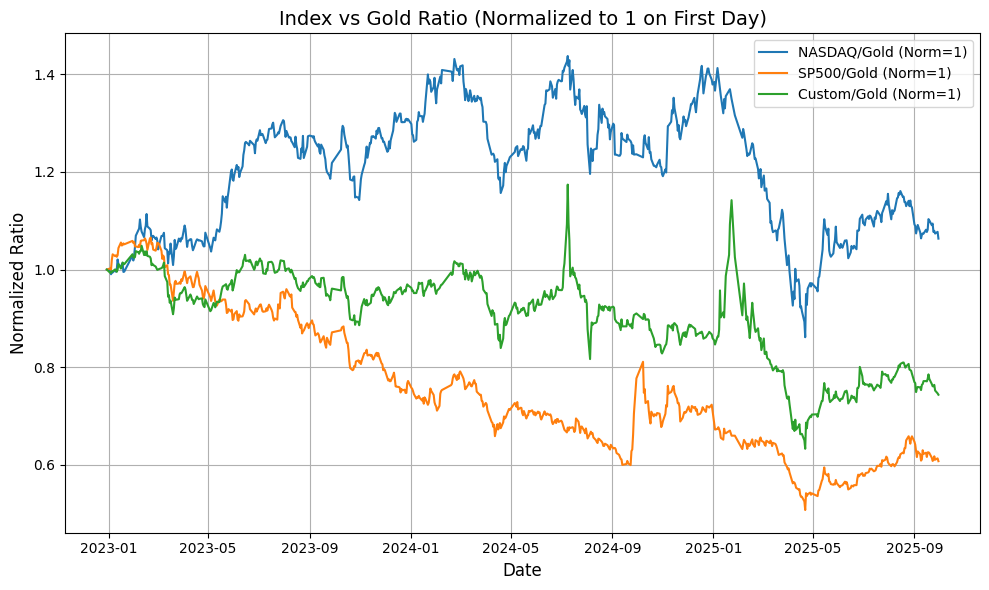

In [29]:
# -*- coding: utf-8 -*-
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt

# ===== 参数 =====
START_DATE   = "2021-01-01"
END_DATE     = "2025-09-30"
ADJUST       = "qfq"       # 前复权："qfq"；不复权：""（空字符串）
CUSTOM       = {"code": "159687", "name": "xitu_ETF"}  # 可改成你想加的任意场内ETF

# 核心 ETF 代码（沿用你上面的约定）
CODES = {
    "NASDAQ": {"code": "159941", "name": "纳斯达克ETF"},
    "SP500":  {"code": "510300", "name": "HUSHENG_ETF"},
    "GOLD":   {"code": "159934", "name": "黄金ETF"},
}

def fetch_close_series(code: str, start_date: str, end_date: str, adjust: str = "qfq") -> pd.Series:
    """从 akshare 获取指定ETF在日期区间内的收盘价序列（按共同交易日对齐用）"""
    sd = start_date.replace("-", "")
    ed = end_date.replace("-", "")
    df = ak.fund_etf_hist_em(symbol=str(code), period="daily", start_date=sd, end_date=ed, adjust=adjust)
    if df is None or df.empty:
        raise RuntimeError(f"{code} 无数据")
    df = df.rename(columns={"日期": "date", "收盘": "close"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    s = pd.to_numeric(df["close"], errors="coerce").dropna()
    s.index = df["date"].values
    s.name = code
    return s

def main():
    # 拉数据
    s_nas = fetch_close_series(CODES["NASDAQ"]["code"], START_DATE, END_DATE, ADJUST)
    s_sp  = fetch_close_series(CODES["SP500"]["code"],  START_DATE, END_DATE, ADJUST)
    s_au  = fetch_close_series(CODES["GOLD"]["code"],   START_DATE, END_DATE, ADJUST)
    s_cus = fetch_close_series(CUSTOM["code"],          START_DATE, END_DATE, ADJUST)

    # 共同交易日内连接
    df = pd.concat([s_nas, s_sp, s_au, s_cus], axis=1, join="inner")
    df.columns = ["NASDAQ", "SP500", "GOLD", "CUSTOM"]
    if df.empty:
        raise RuntimeError("共同交易日为空，请调整日期区间或检查代码。")

    # 计算原始比率
    df["NASDAQ/Gold"] = df["NASDAQ"] / df["GOLD"]
    df["SP500/Gold"]  = df["SP500"]  / df["GOLD"]
    df["Custom/Gold"] = df["CUSTOM"] / df["GOLD"]

    # 归一化（首日=1）
    norm = pd.DataFrame(index=df.index)
    for col in ["NASDAQ/Gold", "SP500/Gold", "Custom/Gold"]:
        first = df[col].iloc[0]
        norm[col + " (Norm=1)"] = df[col] / first if first != 0 else pd.NA

    # —— 中文终端信息 —— #
    print(f"\n===== 结果区间：{START_DATE} ~ {END_DATE} =====")
    print(f"共同交易日数量：{len(df)}")
    print("最后一个交易日：", df.index[-1].strftime("%Y-%m-%d"))
    print("纳斯达克/黄金：{:.6f}".format(df.iloc[-1]["NASDAQ/Gold"]))
    print("标普500/黄金：{:.6f}".format(df.iloc[-1]["SP500/Gold"]))
    print("{} / 黄金：{:.6f}".format(CUSTOM["name"], df.iloc[-1]["Custom/Gold"]))

    # —— 英文图表：原始比率 —— #
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df["NASDAQ/Gold"], label="NASDAQ/Gold")
    plt.plot(df.index, df["SP500/Gold"],  label="HUSHEN/Gold")
    plt.plot(df.index, df["Custom/Gold"], label=f"{CUSTOM['name']}/Gold")
    plt.title("Index vs Gold Ratio (Raw)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ratio", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # —— 英文图表：归一化比率（首日=1） —— #
    plt.figure(figsize=(10, 6))
    for col in norm.columns:
        plt.plot(norm.index, norm[col], label=col)
    plt.title("Index vs Gold Ratio (Normalized to 1 on First Day)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Normalized Ratio", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## 4. 股票搜索

In [1]:
# -*- coding: utf-8 -*-
"""
获取 AkShare 中名称包含关键词的ETF或LOF
并计算成立日期、YTD年化收益、夏普比率、CDaR、最大回撤、相对上证的Beta/Alpha
"""

import pandas as pd
import numpy as np
from datetime import date, datetime
import akshare as ak
import math, time
import os

# ========== 用户配置区域 ==========
FUND_TYPE = "etf"           # 选择 "etf" 或 "lof"
SAVE_ROOT = r"/home/luany/桌面/203_量化交易/测试拟合/results/"   # 保存数据的根路径
KEYWORD = "纳"              # 筛选基金名称的关键词
RISK_FREE_ANNUAL = 0.02     # 无风险利率，默认2%
CDAR_ALPHA = 0.95           # CDaR置信度
# ================================

# 工具函数
def to_returns(price_series):
    return price_series.astype(float).pct_change().dropna()

def to_index(returns, start=1.0):
    return start*(1+returns).cumprod()

def drawdown_series(price_series):
    s = price_series.dropna().astype(float)
    return s / s.cummax() - 1.0

def cdar(drawdowns, alpha=CDAR_ALPHA):
    dd = drawdowns.dropna()
    if dd.empty: return np.nan
    q = dd.quantile(1.0-alpha)
    tail = dd[dd <= q]
    return abs(tail.mean()) if not tail.empty else np.nan

def compute_metrics(price_series, rf_annual=RISK_FREE_ANNUAL):
    rets = to_returns(price_series)
    if len(rets)==0: 
        return dict(ann_return=np.nan, sharpe=np.nan, mdd=np.nan, cdar=np.nan)
    af = 252
    ann_ret = (1+rets).prod()**(af/len(rets))-1
    rf_daily = (1+rf_annual)**(1/af)-1
    excess = rets - rf_daily
    sharpe = (excess.mean()/(excess.std(ddof=1)+1e-12))*math.sqrt(af)
    dd = drawdown_series(price_series)
    return dict(
        ann_return=ann_ret,
        sharpe=sharpe,
        mdd=dd.min(),
        cdar=cdar(dd, CDAR_ALPHA)
    )

def first_day_and_ytd(code, fund_type):
    today = date.today()
    year_start = date(today.year,1,1)
    
    # 根据基金类型选择不同的数据接口
    if fund_type.lower() == "etf":
        data = ak.fund_etf_hist_em(symbol=code, period="daily", 
                                   start_date="20000101", end_date=today.strftime("%Y%m%d"), adjust="qfq")
    elif fund_type.lower() == "lof":
        data = ak.fund_lof_hist_em(symbol=code, period="daily", 
                                   start_date="20000101", end_date=today.strftime("%Y%m%d"), adjust="qfq")
    else:
        raise ValueError("fund_type 必须是 'etf' 或 'lof'")
    
    if data is None or data.empty:
        return None, None, None
        
    df = data.rename(columns={"日期":"date","收盘":"close"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    first = df.index.min().date().strftime("%Y-%m-%d")
    df_y = df[df.index.date>=year_start]
    if df_y.empty: return first, None, df
    start, end = df_y["close"].iloc[0], df_y["close"].iloc[-1]
    ytd_ret = end/start-1.0
    trading_days = len(df_y)
    ann_ytd = (1+ytd_ret)**(252/trading_days)-1 if trading_days>0 else None
    return first, ann_ytd, df

def fetch_sh_index(start_date):
    today = date.today().strftime("%Y%m%d")
    df = ak.stock_zh_index_daily_em(symbol="sh000001")
    df = df.rename(columns={"close":"close","date":"date"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    return df[df.index>=pd.to_datetime(start_date)]

def calc_beta_alpha(fund_ret, bench_ret, rf_annual=RISK_FREE_ANNUAL):
    df = pd.concat([fund_ret, bench_ret], axis=1).dropna()
    if df.empty: return np.nan, np.nan
    y, X = df.iloc[:,0].values, df.iloc[:,1].values
    beta = np.cov(y,X)[0,1]/np.var(X)
    alpha = y.mean() - beta*X.mean()
    alpha_ann = alpha*252
    return beta, alpha_ann

def main():
    # 根据基金类型获取数据
    if FUND_TYPE.lower() == "etf":
        funds = ak.fund_etf_spot_ths()
        # print(funds)
        print(f"获取ETF基金数据，共{len(funds)}只")
    elif FUND_TYPE.lower() == "lof":
        funds = ak.fund_lof_spot_em()
        print(f"获取LOF基金数据，共{len(funds)}只")
    else:
        raise ValueError("FUND_TYPE 必须是 'etf' 或 'lof'")
    
    # 筛选包含关键词的基金
    if KEYWORD:
        funds = funds[funds["基金名称"].str.contains(KEYWORD, na=False)]
        print(f"筛选包含'{KEYWORD}'的基金，剩余{len(funds)}只")
    
    if funds.empty:
        print(f"未找到包含'{KEYWORD}'的{FUND_TYPE.upper()}基金")
        return
    
    rows = []
    sh_index = None
    
    for i, row in funds.iterrows():
        code, name = row["基金代码"], row["基金名称"]
        print(f"处理: {name}({code})")
        try:
            first, ann_ytd, df = first_day_and_ytd(code, FUND_TYPE)
            if df is None: 
                print(f"  ⚠️ 无法获取{name}的历史数据")
                continue
                
            metrics = compute_metrics(df["close"])
            
            if sh_index is None: 
                sh_index = fetch_sh_index(df.index.min())
                
            fund_ret = to_returns(df["close"])
            bench_ret = to_returns(sh_index["close"]).reindex(fund_ret.index).dropna()
            fund_ret = fund_ret.loc[bench_ret.index]
            beta, alpha = calc_beta_alpha(fund_ret, bench_ret)
            
            rows.append({
                "代码": code,
                "名称": name,
                "成立日期": first,
                "YTD年化收益": ann_ytd,
                "夏普": metrics["sharpe"],
                "CDaR[95%]": metrics["cdar"],
                "最大回撤": metrics["mdd"],
                "Beta(相对上证)": beta,
                "Alpha(年化)": alpha
            })
            
        except Exception as e:
            print(f"  ⚠️ {code} {name} 处理失败: {e}")
            continue
    
    if not rows:
        print("没有成功处理任何基金数据")
        return
        
    result = pd.DataFrame(rows)
    result = result.sort_values("YTD年化收益", ascending=False)
    
    # 格式化显示
    pretty = result.copy()
    for col in ["YTD年化收益", "夏普", "CDaR[95%]", "最大回撤", "Beta(相对上证)", "Alpha(年化)"]:
        pretty[col] = pretty[col].apply(
            lambda x: "" if pd.isna(x) else f"{x:.2%}" if col in ["YTD年化收益", "CDaR[95%]", "最大回撤", "Alpha(年化)"] else f"{x:.3f}"
        )
    
    print(pretty.to_string(index=False))
    
    # 保存文件
    today = datetime.today().strftime("%Y%m%d")
    
    # 确保保存目录存在
    if not os.path.exists(SAVE_ROOT):
        os.makedirs(SAVE_ROOT)
        print(f"创建目录: {SAVE_ROOT}")
    
    # 构建保存路径
    filename = f"{FUND_TYPE.upper()}_{KEYWORD}_基金分析_{today}.csv"
    save_path = os.path.join(SAVE_ROOT, filename)
    
    result.to_csv(save_path, index=False, encoding="utf-8-sig")
    print(f"已保存CSV文件: {save_path}")

if __name__ == "__main__":
    main()

获取ETF基金数据，共1413只
筛选包含'纳'的基金，剩余14只
处理: 汇添富纳斯达克生物科技ETF(513290)


  0%|          | 0/13 [00:00<?, ?it/s]

处理: 景顺长城纳斯达克科技ETF(QDII)(159509)
处理: 易方达纳斯达克100ETF(QDII)(159696)
处理: 富国纳斯达克100ETF(QDII)(513870)
处理: 汇添富纳斯达克100ETF(159660)
处理: 招商纳斯达克100ETF(QDII)(159659)
处理: 华安纳斯达克100ETF(QDII)(159632)
处理: 博时纳斯达克100ETF(513390)
处理: 嘉实纳斯达克100ETF(QDII)(159501)
处理: 纳指100(513110)
处理: 广发纳指100ETF(159941)
处理: 国泰纳斯达克100(QDII-ETF)(513100)
处理: 大成纳斯达克100ETF(QDII)(159513)
处理: 华夏纳斯达克100ETF(QDII)(513300)
    代码                  名称       成立日期 YTD年化收益    夏普 CDaR[95%]    最大回撤 Beta(相对上证) Alpha(年化)
159509 景顺长城纳斯达克科技ETF(QDII) 2023-08-08  45.54% 1.290    23.35% -30.47%      0.269    39.97%
513290      汇添富纳斯达克生物科技ETF 2022-08-29  33.18% 0.701    19.89% -25.77%      0.213    15.42%
159501  嘉实纳斯达克100ETF(QDII) 2023-06-14  17.33% 1.083    17.12% -24.84%      0.276    22.61%
159659  招商纳斯达克100ETF(QDII) 2023-04-25  17.15% 1.322    16.86% -25.01%      0.274    28.12%
513100 国泰纳斯达克100(QDII-ETF) 2013-05-15  17.02% 0.886    24.54% -28.49%      0.294    24.74%
159696 易方达纳斯达克100ETF(QDII) 2023-08-25  16.96% 1.174    17.39% -25.11%      0.249

下面表格中，哪些股票综合指标比较好，纳指、标普分别列出前3个（综合指标指成立较早，YTD较好，夏普较好，cdar较小，最大回撤较小，beta较好，alpha较高）
``` csv
代码           名称       成立日期 YTD年化收益    夏普 CDaR[95%]    最大回撤 Beta(相对上证) Alpha(年化)
159509      纳指科技ETF 2023-08-08  38.00% 1.225    23.45% -30.47%      0.206    38.55%
513390     纳指100ETF 2023-05-08  23.56% 1.482    18.90% -26.80%      0.231    32.87%
513100        纳指ETF 2013-05-15  14.52% 0.884    24.59% -28.49%      0.209    29.75%
159659   纳斯达克100ETF 2023-04-25  13.46% 1.338    17.14% -25.01%      0.226    28.35%
513870      纳指ETF富国 2023-11-02  13.34% 1.147    17.61% -24.54%      0.134    28.88%
159696     纳指ETF易方达 2023-08-25  12.53% 1.156    17.70% -25.11%      0.199    25.11%
159501      纳指ETF嘉实 2023-06-14  12.10% 1.038    17.40% -24.84%      0.237    21.91%
513110   纳斯达克100ETF 2023-03-20  11.93% 1.423    17.16% -25.03%      0.227    28.51%
159513 纳斯达克100指数ETF 2023-07-28  11.40% 0.897    16.88% -24.52%      0.237    19.51%
159941        纳指ETF 2015-07-13  10.42% 0.787    25.70% -31.13%      0.211    28.90%
513290    纳指生物科技ETF 2022-08-29  10.41% 0.451    20.00% -25.77%      0.146     8.21%
159660     纳指100ETF 2023-04-17   9.75% 1.375    18.97% -27.19%      0.239    29.27%
159632      纳斯达克ETF 2022-08-03   8.23% 1.013    19.12% -26.13%      0.226    28.44%
513300      纳斯达克ETF 2020-11-05   6.93% 0.751    25.28% -26.99%      0.174    29.54%
```
``` csv
    代码         名称       成立日期 YTD年化收益    夏普 CDaR[95%]    最大回撤 Beta(相对上证) Alpha(年化)
562060  XD标普红利ETF 2023-12-28  16.67% 0.753    16.91% -20.04%      0.934    -3.59%
513650 标普500ETF南方 2023-04-04   9.46% 1.218    13.70% -21.15%      0.186    18.42%
159502  标普生物科技ETF 2024-01-10   6.66% 0.095    27.71% -32.34%      0.163     1.34%
513500   标普500ETF 2014-01-15   6.43% 0.741    24.31% -29.70%      0.137    20.43%
159655      标普ETF 2022-10-25   3.11% 0.883    20.46% -27.88%      0.181    19.95%
159612   标普500ETF 2022-05-20   1.57% 0.814    14.09% -22.33%      0.118    22.60%
159518    标普油气ETF 2023-11-15  -4.96% 0.025    32.86% -38.94%      0.328    -1.34%
513350    标普油气ETF 2023-11-28  -8.23% 0.089    32.48% -38.53%      0.324    -0.57%
159529    标普消费ETF 2024-02-02 -11.89% 0.662    28.20% -32.73%      0.191    22.45%
```